In [1]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # using specific GPU
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)

from compatible.likelihoods import MultiClass, Gaussian
from compatible.kernels import RBF, White
from gpflow.models.svgp import SVGP
from gpflow.training import AdamOptimizer, ScipyOptimizer
from scipy.stats import mode
from scipy.cluster.vq import kmeans2
import gpflow
from gpflow.mean_functions import Identity, Linear
from gpflow.mean_functions import Zero
from gpflow import autoflow, params_as_tensors, ParamList
import pandas as pd
import itertools
pd.options.display.max_rows = 999
import gpflow_monitor

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.io import loadmat
from gpflow_monitor import *
print('tf_ver:', tf.__version__, 'gpflow_ver:', gpflow.__version__)
from tensorflow.python.client import device_lib
print('avail devices:\n'+'\n'.join([x.name for x in device_lib.list_local_devices()]))
from jack_utils.common import time_it
import sys
import gpflow.training.monitor as mon

# our impl
from dgp_graph import *

np.random.seed(123)

tf_ver: 1.15.0 gpflow_ver: 1.5.0
avail devices:
/device:CPU:0
/device:XLA_CPU:0
/device:XLA_GPU:0


Using TensorFlow backend.


In [2]:
def agg_func(adj, batch_x):
    # adj(n, n),  batch_x（batch, n, feat）
    # out: selected(batch, n, n*feat)
    a_ = np.expand_dims(adj, axis=-1)
    x_ = np.expand_dims(batch_x, axis=1)  # 维度插入应该在node维度之前
    selected = a_*x_
    return selected.reshape(batch_x.shape[0], batch_x.shape[1], -1)

In [3]:
def gen_data(nn, dg=3, trainsize=500, testsize=100, ns=1.0):
    gmat = np.eye(nn)
    for i in range(nn):
        r = np.random.permutation(nn)
        gmat[i, r[:dg]] = 1
    gmat = np.minimum(1, gmat+gmat.T)
    gmat = gmat.astype('int32')
    
    X, Y = np.random.randn(trainsize+testsize, nn), np.random.randn(trainsize+testsize, nn)*ns
#     for i in range(nn):
#         X[:, i] += np.sin(i)*ns + i
#     Y=X+10
    for i in range(trainsize+testsize):
        for j in range(nn):
            connetedx = X[i, gmat[:, j] == 1]
            Y[i, j] += np.sum(connetedx)
            
    Xs, Ys = X[-testsize:, :], Y[-testsize:, :]
    X, Y = X[:trainsize, :], Y[:trainsize, :]
    
    # normalize Y
    mu_y = np.mean(Y, axis=0)
    std_y = np.std(Y, axis=0)
    
    Y = (Y-mu_y)/std_y
    Ys = (Ys-mu_y)/std_y
    
    return gmat, X, Y, Xs, Ys

In [4]:
nodes = 500
(gmat, trX, trY, Xs, Ys) = gen_data(nodes, dg=3, trainsize=500, testsize=200, ns=1.0)

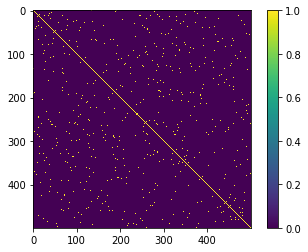

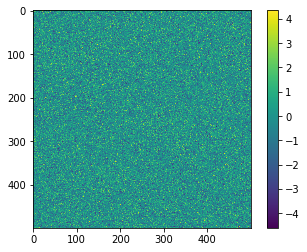

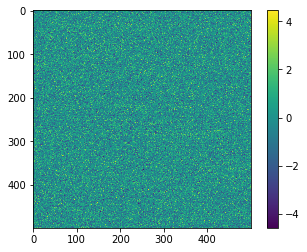

In [5]:
plt.figure(); plt.imshow(gmat); plt.colorbar()

plt.figure(); plt.imshow(trX); plt.colorbar()
plt.figure(); plt.imshow(trY); plt.colorbar()

In [6]:
M=50

Z = np.stack([kmeans2(trX[:,i], M, minit='points')[0] for i in range(nodes)],axis=1)  # (M=s2=10, n, d_in=5)
print('inducing points Z: {}'.format(Z.shape))

inducing points Z: (50, 500)


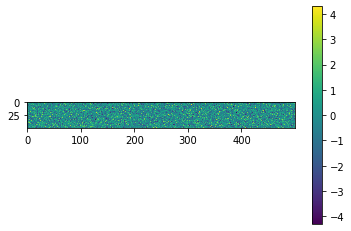

In [7]:
plt.imshow(Z); plt.colorbar()

In [8]:
node_id = 0

# Training

In [9]:
adj = gmat.astype('float64')
input_adj = adj # adj  / np.identity(adj.shape[0]) /  np.ones_like(adj)
with gpflow.defer_build():
    adj_dgpg = DGPG(trX[:,:,None], trY[:,:,None], Z[:,:,None], [1], Gaussian(), input_adj,
                  agg_op_name='concat3d', ARD=False,
                  is_Z_forward=True, mean_trainable=False, out_mf0=True,
                  num_samples=1, minibatch_size=None
                 )
    # m_sgp = SVGP(X, Y, kernels, Gaussian(), Z=Z, minibatch_size=minibatch_size, whiten=False)
adj_dgpg.compile()
model1 = adj_dgpg

input-output dim (1(agg:500)->1)
func __init__ consumed 0.5s


In [ ]:
%%time

session = model1.enquire_session()
global_step = mon.create_global_step(session)

print_task = mon.PrintTimingsTask()\
    .with_name('print')\
    .with_condition(mon.PeriodicIterationCondition(10))\

with mon.LogdirWriter('./exp/toy/tempx') as writer:
    tensorboard_task = mon.ModelToTensorBoardTask(writer, model1)\
        .with_name('tensorboard')\
        .with_condition(mon.PeriodicIterationCondition(100))\
        .with_exit_condition(True)
    monitor_tasks = [tensorboard_task] # [print_task, tensorboard_task]

    optimiser = gpflow.train.AdamOptimizer(0.01)
    
    with mon.Monitor(monitor_tasks, session, global_step, print_summary=True) as monitor:
        optimiser.minimize(model1, step_callback=monitor, global_step=global_step, maxiter=1000)

In [ ]:
model1.as_pandas_table()

In [ ]:
kzz1 = model1.layers[0].kern.compute_K_symm(model1.layers[0].feature.Z.value) # ~Kzz
print(kzz1.shape)

In [ ]:
s1 = model1.layers[0].q_sqrt.value[node_id, 0] * model1.layers[0].q_sqrt.value[node_id, 0].T # ~S

Q1 = kzz1[node_id] - s1 # ~Q = ~Kzz - ~S

print(Q1.shape)

In [ ]:
X_agg1 = agg_func(adj, trX[:,:,None])
Z_agg1 = agg_func(adj, Z[:,:,None])

In [ ]:
knxz1 = model1.layers[0].kern.compute_K(X_agg1, Z_agg1)

In [ ]:
knxz1.shape

In [ ]:
kxz1_lst = [np.linalg.norm(v) for v in knxz1[0]] # list of ~k

# mu_kxz1 = np.mean(knxz1[node_id], axis=0) # ~k

In [ ]:
norm_kxz1 = np.mean(kxz1_lst) # \~k\

In [ ]:
norm_kxz1 # \~k\

fully connected, no graph structure

In [ ]:
adj_fc = np.ones_like(adj)
X_fc1 = agg_func(adj_fc, trX[:,:,None])
Z_fc1 = agg_func(adj_fc, Z[:,:,None])

In [ ]:
knxz_fc1 = model1.layers[0].kern.compute_K(X_fc1, Z_fc1)

kxz2_lst = [np.linalg.norm(v) for v in knxz_fc1[0]] # list of k
norm_fc_kxz1 = np.mean(kxz2_lst) # \~k\
# mu_fc_kxz1 = np.mean(knxz_fc1[node_id], axis=0)
# norm_fc_kxz1 = np.linalg.norm(mu_fc_kxz1)

In [ ]:
norm_fc_kxz1 # \k\

In [ ]:
kzz1fc = model1.layers[0].kern.compute_K_symm(Z_fc1)
print(kzz1fc.shape)

In [ ]:
Q1fc = kzz1fc[node_id] - s1

print(Q1fc.shape)

# Result summary
With graph structure

In [37]:
np.set_printoptions(threshold=9999)

In [38]:
knxz1[0, node_id, :] # ~k(0)

array([0.76393197, 0.79135258, 0.87229184, 0.88258414, 0.85438739,
       0.7185199 , 0.73199928, 0.91365417, 0.74741867, 0.87389977,
       0.85558779, 0.71989343, 0.75040167, 0.75973399, 0.84988572,
       0.87352205, 0.73259504, 0.80444939, 0.86330949, 0.89066878,
       0.73411221, 0.84416383, 0.82632659, 0.75628612, 0.81287489,
       0.8156078 , 0.86304462, 0.84926434, 0.81902331, 0.71729526,
       0.75164101, 0.74217576, 0.91665355, 0.86421199, 0.73793076,
       0.87191355, 0.87897055, 0.74052578, 0.89737501, 0.7743946 ,
       0.87932437, 0.88445583, 0.74905654, 0.89603081, 0.91706103,
       0.70021686, 0.59054228, 0.88808645, 0.88770591, 0.84556268])

In [39]:
np.linalg.norm(knxz1[0, node_id, :]) # \~k(0)\

5.778900809438305

In [40]:
knxz_fc1.shape

(500, 500, 50)

In [41]:
knxz_fc1[0, node_id, :] # k(0)

array([6.91197039e-12, 4.01115096e-11, 1.13901888e-11, 2.71367450e-11,
       9.02256156e-12, 1.05496317e-12, 2.93515620e-11, 1.59461854e-11,
       7.44831474e-13, 1.77025445e-10, 4.54272629e-12, 7.96153407e-11,
       6.47331178e-11, 1.95889854e-11, 4.43637150e-12, 4.19578456e-12,
       1.00871532e-11, 8.31696564e-12, 1.28978292e-12, 1.43911898e-11,
       2.34037179e-12, 1.81917273e-11, 7.75615524e-11, 9.80351334e-12,
       6.71909963e-12, 2.05840148e-12, 7.65518377e-11, 2.49520187e-11,
       3.13849758e-13, 9.10800661e-12, 2.63345961e-12, 2.49404920e-12,
       2.40294374e-11, 9.72795025e-11, 4.71329043e-12, 2.99121187e-12,
       1.94322133e-12, 6.57943049e-11, 5.82737289e-11, 8.23255263e-12,
       3.05109679e-11, 3.94712509e-11, 1.28414690e-12, 7.43326090e-13,
       9.71736920e-11, 1.00637046e-11, 1.51629045e-12, 2.44376007e-11,
       1.33315714e-11, 1.85450106e-12])

In [42]:
np.linalg.norm(knxz_fc1[0, node_id, :]) # \k(0)\

3.0028430627913754e-10

In [43]:
kzz1inv = np.linalg.inv(kzz1[node_id]) # ~Kzz^-1

In [44]:
M1 = kzz1inv * Q1 * kzz1inv # ~M = ~Kzz^-1 ~Q ~Kzz^-1

In [45]:
_, lamb1, _ = np.linalg.svd(M1)
print(lamb1) # ~lambda -> # ~lambda_min

[7.94348695e+07 1.16811520e+07 8.40723817e+06 6.07974259e+06
 2.95590340e+06 2.70328488e+06 1.86711311e+06 1.67380036e+06
 1.60496013e+06 1.29334798e+06 1.10198279e+06 1.08147113e+06
 9.63790952e+05 7.34730974e+05 5.70736286e+05 5.29712805e+05
 3.22768737e+05 3.18001209e+05 3.11810425e+05 2.02321845e+05
 1.92556457e+05 1.68259182e+05 1.39332425e+05 1.31343120e+05
 1.18398147e+05 1.12461343e+05 1.04666148e+05 7.12025072e+04
 5.02294013e+04 4.83947745e+04 4.76714562e+04 4.34997774e+04
 3.97494767e+04 3.27380616e+04 3.01044533e+04 2.89337604e+04
 2.67689136e+04 2.50250825e+04 1.59240678e+04 1.35486545e+04
 1.34236446e+04 1.24683020e+04 1.00443597e+04 7.09509485e+03
 1.63609091e+03 1.60461761e+03 9.66786029e+02 1.66231221e+01
 4.03423838e+00 2.79966963e+00]


Without graph structure

In [46]:
kzz1invfc = np.linalg.inv(kzz1fc[node_id]) # Kzz

In [47]:
M1fc = kzz1invfc * Q1fc * kzz1invfc

In [48]:
_, lamb1fc, _ = np.linalg.svd(M1fc)
print(lamb1fc)

[1.04316935 1.043156   1.04315254 1.04295613 1.04274634 1.04218125
 1.04179291 1.04176429 1.04171054 1.04158222 1.04144198 1.04130842
 1.04130758 1.04115486 1.04107475 1.04089746 1.0407709  1.04046438
 1.04039019 1.040064   1.03987765 1.03986852 1.03965631 1.03950334
 1.03936365 1.03893089 1.03859864 1.0385794  1.03851343 1.03780161
 1.0371603  1.03702711 1.03564403 1.03531682 1.0349425  1.03476092
 1.03258363 1.03198296 1.03161126 1.03015371 1.02935866 1.02916016
 1.02825364 1.02236458 1.02157934 1.02091635 0.98028487 0.70490531
 0.64493093 0.58623487]
